<h1> ALL MODELS IN ONE NOTEBOOK

<h1> Prophet

<h3>IMPORTS

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from pandas_profiling import ProfileReport
from matplotlib import pyplot
import datetime
from datetime import date
import calendar
from calendar import monthrange
import fbprophet

import holidays

In [2]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #DATUM
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von DATUM
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'min_kapaz',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'datum': date_list[i], 'datum_tag': calendar.day_name[date_list[i].weekday()],
                 'eingänge_pro_tag': summe, 'fahrten_pro_tag_soll':summesoll, 'fahrten_pro_tag_ist':summeist,
                 'genauigkeit_pro_tag':prozent,'kapazität_täglich':kapaz_daily, 'tag=feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['datum','datum_tag','eingänge_pro_tag','fahrten_pro_tag_soll','fahrten_pro_tag_ist','genauigkeit_pro_tag','kapazität_täglich','tag=feiertag'])

In [23]:
training = by_hour_df.iloc[0:1554]
test = by_hour_df.iloc[1554:]

In [24]:
columns_to_drop = ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl","min_kapaz"]

training = training.drop(columns= columns_to_drop)
test = test.drop(columns= columns_to_drop)

<h2> Plot von Training und Test, Unterschied

In [5]:
from matplotlib import pyplot
%matplotlib qt

print('Observations: %d' % (len(by_hour_df)))
print('Training Observations: %d' % (len(training)))
print('Testing Observations: %d' % (len(test)))

pyplot.plot(training["P hochgerechnet"])
pyplot.plot([None for i in training["P hochgerechnet"]] + [x for x in test["P hochgerechnet"]])
pyplot.xlabel("Anzahl der Beobachtungen")
pyplot.ylabel("Eingänge der Passagiere")
pyplot.title("Visualisierung der Training- und Testdaten")

pyplot.show()


Observations: 1932
Training Observations: 1554
Testing Observations: 378


<h2> Vorbereitungen für Prophet

In [9]:
training.rename(columns={'Datum': 'ds', 'P hochgerechnet': 'y'}, inplace = True)

In [10]:
test.rename(columns={'Datum': 'ds', 'P hochgerechnet': 'y'}, inplace = True)

In [11]:
austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

In [12]:
austria_holidays = pd.DataFrame({
  'holiday': 'feiertage',
  'ds': austria_holidays
})

<h2> Vorhersage basierend auf historischen Daten (trainings-set)

In [13]:
# Make the prophet model and fit on the data
training_prophet = fbprophet.Prophet(holidays = austria_holidays, changepoint_prior_scale=0.05, daily_seasonality = True , weekly_seasonality = True, yearly_seasonality = False)
training_prophet.fit(training)

In [14]:
# Make a future dataframe for .. hours, days, years
training_forecast = training_prophet.make_future_dataframe(periods=360, freq='H')

#entweder auf historie -> training_forecast oder auf test_set
training_forecast = training_prophet.predict(training_forecast)


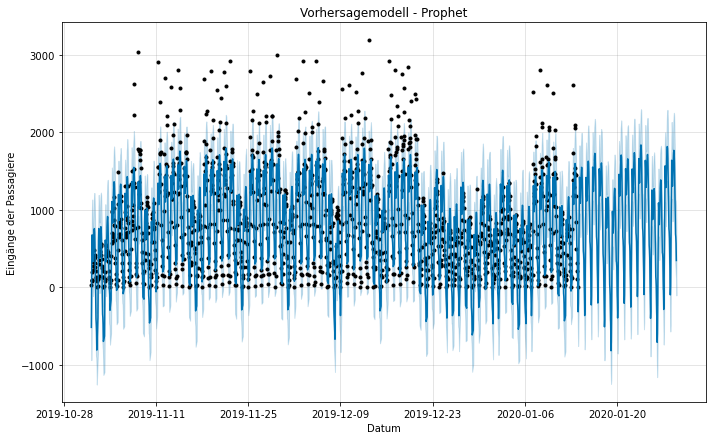

In [15]:
training_prophet.plot(training_forecast, xlabel = 'Datum', ylabel = 'Eingänge der Passagiere')
plt.title('Vorhersagemodell - Prophet');

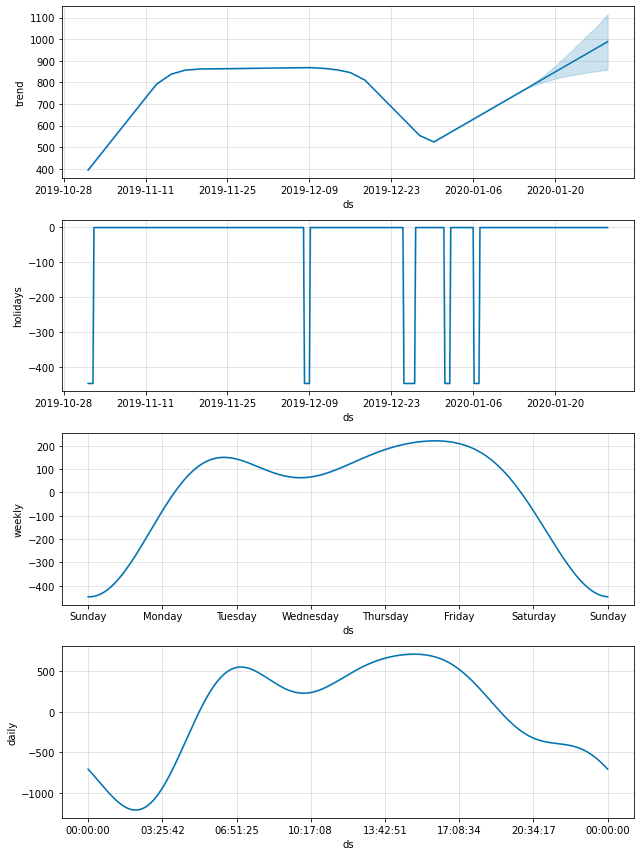

In [16]:
training_prophet.plot_components(training_forecast,uncertainty = True);

<h2> Vorhersage basierend auf test-set

In [17]:
# Make the prophet model and fit on the data
training_prophet_aufTest = fbprophet.Prophet(holidays = austria_holidays, changepoint_prior_scale=0.05, daily_seasonality = True , weekly_seasonality = True, yearly_seasonality = False)
training_prophet_aufTest.fit(training)


In [14]:
%timeit -n 1 -r 1 training_prophet_aufTest.predict(df=test.reset_index() \
                                   .rename(columns={'Datum':'ds'}))

1.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [131]:
# Predict on test set
training_forecast_aufTest = training_prophet_aufTest.predict(df=test.reset_index() \
                                   .rename(columns={'Datum':'ds'}))

In [29]:
training_prophet_aufTest.plot(training_forecast_aufTest, xlabel = 'Datum', ylabel = 'Passagiere')
plt.title('Vorhersagemodell - Prophet');

In [132]:
training_prophet_aufTest.plot_components(training_forecast_aufTest,uncertainty = True);

In [27]:
training_forecast = training_forecast.set_index('ds')

training_forecast = training_forecast['2019-11-01':'2020-01-13']

In [28]:
from sklearn.metrics import mean_squared_error
prophet_error = mean_squared_error(training["P hochgerechnet"],training_forecast["yhat"], squared = False)
print("Prophet RMSE ERROR: ", prophet_error )

Prophet RMSE ERROR:  349.6362535700918


In [29]:
from sklearn.metrics import r2_score, mean_absolute_error

In [31]:
r2_score(training["P hochgerechnet"],training_forecast["yhat"])

0.07085952897352926

In [32]:
mean_absolute_error(training["P hochgerechnet"],training_forecast["yhat"])

254.6401915103317

<h1> LSTM

<h3>IMPORTS

In [36]:
import os
import glob
import numpy as np
import pandas as pd

import datetime
import calendar
import holidays
from datetime import date
from calendar import monthrange
from matplotlib import pyplot
import matplotlib.pylab as plt

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

%matplotlib inline

In [37]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #DATUM
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von DATUM
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'min_kapaz',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'datum': date_list[i], 'datum_tag': calendar.day_name[date_list[i].weekday()],
                 'eingänge_pro_tag': summe, 'fahrten_pro_tag_soll':summesoll, 'fahrten_pro_tag_ist':summeist,
                 'genauigkeit_pro_tag':prozent,'kapazität_täglich':kapaz_daily, 'tag=feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['datum','datum_tag','eingänge_pro_tag','fahrten_pro_tag_soll','fahrten_pro_tag_ist','genauigkeit_pro_tag','kapazität_täglich','tag=feiertag'])

In [38]:
training_set = by_hour_df.iloc[0:1554, 5:6].values
test_set = by_hour_df.iloc[1554:, 5:6].values

Normalisierung

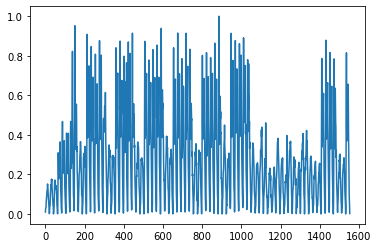

In [39]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

pyplot.plot(training_set_scaled)

Strukturerstellung für die Lag/Timesteps

In [40]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []

for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [42]:
print(X_train.shape)

(1494, 50, 1)


In [172]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50, return_sequences = True))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
%timeit -n 1 -r 1 model.add(LSTM(units = 50))
%timeit -n 1 -r 1 model.add(Dropout(0.2))

# Adding the output layer
%timeit -n 1 -r 1 model.add(Dense(units = 1))

# Compiling the RNN
%timeit -n 1 -r 1 model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
%timeit -n 1 -r 1 model.fit(X_train, y_train, epochs = 100, batch_size = 32)

222 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.38 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
203 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
207 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
207 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.83 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.96 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Epoch 1/100
47/47 [==============================] - 2s 46ms/step - loss: 0.2150
Epoch 2/100
47/47 [==============================] - 2s 44ms/step - loss: 0.1996
Epoch 3/100
47/47 [==============================] - 2s 44ms/step - loss: 0.1715
Epoch 4/100
47/47 [==============================] - 2s 44ms/step - loss: 0.1565
Epoch 5/100
47/47 [===========

In [174]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [176]:
model.history.history

{'loss': [0.2149977684020996,
  0.19959542155265808,
  0.17145046591758728,
  0.15651415288448334,
  0.15305961668491364,
  0.141653910279274,
  0.1341247707605362,
  0.1345692276954651,
  0.12698571383953094,
  0.12638837099075317,
  0.12240953743457794,
  0.12281584739685059,
  0.12500536441802979,
  0.11880000680685043,
  0.118752121925354,
  0.11713682115077972,
  0.12057710438966751,
  0.11330562084913254,
  0.11118129640817642,
  0.1124446913599968,
  0.11258722096681595,
  0.11048202961683273,
  0.11486229300498962,
  0.10428523272275925,
  0.10778788477182388,
  0.10777688026428223,
  0.1069692000746727,
  0.101596400141716,
  0.10634896159172058,
  0.10217419266700745,
  0.10206059366464615,
  0.09912049025297165,
  0.09582827985286713,
  0.09951537847518921,
  0.09492918848991394,
  0.09639392793178558,
  0.09547487646341324,
  0.0884542316198349,
  0.09134205430746078,
  0.09141506999731064,
  0.08597565442323685,
  0.08421633392572403,
  0.08053276687860489,
  0.08066092431

In [37]:
dataset_train = by_hour_df.iloc[0:1554, 5:6]
dataset_test = by_hour_df.iloc[1554:, 5:6]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(len(dataset_total) - len(dataset_test) - 60)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

print(inputs.shape[0])

1494
438


In [38]:
X_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-50:i, 0])
    


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(378, 50, 1)


In [44]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

<h2> Vergleich der echten Werte und Vorhersage LSTM

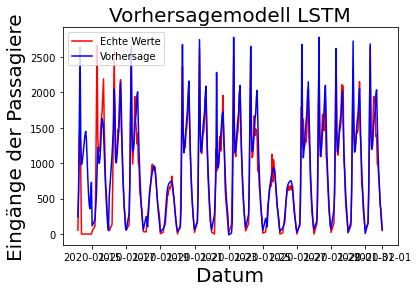

In [46]:
# Visualising the results
plt.plot(by_hour_df.loc[1554:, "Datum"],dataset_test.values, color = "red", label = "Echte Werte")
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price, color = "blue", label = "Vorhersage")

plt.title('Vorhersagemodell LSTM',fontsize =20)
plt.xlabel('Datum',fontsize =20)
plt.ylabel('Eingänge der Passagiere',fontsize =20)
plt.legend()
plt.show()

<h2> Plot von Training, Test und P hochgerechnet

In [19]:
training_set = by_hour_df.iloc[0:1554, 5:6]
test_set = by_hour_df.iloc[1554:, 5:6]

test_set['Predictions']=predicted_stock_price
plt.plot(training_set["P hochgerechnet"], label = "Training")
plt.plot(test_set["Predictions"], label= "LSTM Vorhersage")
plt.grid(color='grey', linewidth=0.5)

plt.title('Vorhersagemodell - LSTM', fontsize =45)
plt.xlabel('Anzahl der Beobachtungen', fontsize =35)
plt.ylabel('Eingänge der Passagiere', fontsize =35)
plt.legend()
plt.show()


In [12]:
plt.close("all")
%matplotlib qt

In [27]:
test_set['Predictions']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# from matplotlib import pyplot
# %matplotlib qt

# print('Observations: %d' % (len(by_hour_df)))
# print('Training Observations: %d' % (len(training_set)))
# print('Testing Observations: %d' % (len(test_set)))
# pyplot.plot(training_set)
# pyplot.plot([None for i in training_set["P hochgerechnet"]] + [x for x in test_set])
# pyplot.show()

<h1> ARIMA

<h3>IMPORTS

In [47]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import datetime
from datetime import date

import calendar
from calendar import monthrange
import holidays

from pandas_profiling import ProfileReport
import itertools

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline

<h3>Alle Dateien die im Ordner sind werden eingelesen und zum Dataframe hinzugefügt</h3>

In [77]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #DATUM
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von DATUM
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'min_kapaz',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'datum': date_list[i], 'datum_tag': calendar.day_name[date_list[i].weekday()],
                 'eingänge_pro_tag': summe, 'fahrten_pro_tag_soll':summesoll, 'fahrten_pro_tag_ist':summeist,
                 'genauigkeit_pro_tag':prozent,'kapazität_täglich':kapaz_daily, 'tag=feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['datum','datum_tag','eingänge_pro_tag','fahrten_pro_tag_soll','fahrten_pro_tag_ist','genauigkeit_pro_tag','kapazität_täglich','tag=feiertag'])

In [99]:
training = by_hour_df.iloc[0:1554]
test = by_hour_df.iloc[1554:]

In [100]:
training = training.drop(columns= ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl","min_kapaz"])
test = test.drop(columns= ["Wochentag","Feiertag","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl", "min_kapaz"])



In [ ]:
print(training)
print(test)

In [50]:
test.head(30)

,Datum,Wochentag,Tageszeit,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,min_kapaz,Feiertag
1554,2020-01-14 04:00:00,Tuesday,04:00 - 04:59,8,1,54.000000,129,0
1555,2020-01-14 05:00:00,Tuesday,05:00 - 05:59,20,3,737.500000,387,0
1556,2020-01-14 06:00:00,Tuesday,06:00 - 06:59,22,2,1354.989800,258,0
1557,2020-01-14 07:00:00,Tuesday,07:00 - 07:59,20,1,1530.000000,129,0
1558,2020-01-14 08:00:00,Tuesday,08:00 - 08:59,19,2,880.543100,258,0
1559,2020-01-14 09:00:00,Tuesday,09:00 - 09:59,17,0,0.000000,0,0
1560,2020-01-14 10:00:00,Tuesday,10:00 - 10:59,16,0,0.000000,0,0
1561,2020-01-14 11:00:00,Tuesday,11:00 - 11:59,16,0,0.000000,0,0
1562,2020-01-14 12:00:00,Tuesday,12:00 - 12:59,17,0,0.000000,0,0
1563,2020-01-14 13:00:00,Tuesday,13:00 - 13:59,16,0,0.000000,0,0


In [101]:
training = training.set_index('Datum')
training.index

DatetimeIndex(['2019-11-01 04:00:00', '2019-11-01 05:00:00',
               '2019-11-01 06:00:00', '2019-11-01 07:00:00',
               '2019-11-01 08:00:00', '2019-11-01 09:00:00',
               '2019-11-01 10:00:00', '2019-11-01 11:00:00',
               '2019-11-01 12:00:00', '2019-11-01 13:00:00',
               ...
               '2020-01-13 15:00:00', '2020-01-13 16:00:00',
               '2020-01-13 17:00:00', '2020-01-13 18:00:00',
               '2020-01-13 19:00:00', '2020-01-13 20:00:00',
               '2020-01-13 21:00:00', '2020-01-13 22:00:00',
               '2020-01-13 23:00:00', '2020-01-13 23:59:59'],
              dtype='datetime64[ns]', name='Datum', length=1554, freq=None)

In [102]:
training.loc['2019-11-01']

,P hochgerechnet
Datum,
2019-11-01 04:00:00,30.000000
2019-11-01 05:00:00,87.083333
2019-11-01 06:00:00,95.333333
2019-11-01 07:00:00,97.333333
2019-11-01 08:00:00,195.000000
2019-11-01 09:00:00,229.500000
2019-11-01 10:00:00,279.000000
2019-11-01 11:00:00,332.250000
2019-11-01 12:00:00,365.250000


In [103]:
test = test.set_index('Datum')
test.index

DatetimeIndex(['2020-01-14 04:00:00', '2020-01-14 05:00:00',
               '2020-01-14 06:00:00', '2020-01-14 07:00:00',
               '2020-01-14 08:00:00', '2020-01-14 09:00:00',
               '2020-01-14 10:00:00', '2020-01-14 11:00:00',
               '2020-01-14 12:00:00', '2020-01-14 13:00:00',
               ...
               '2020-01-31 15:00:00', '2020-01-31 16:00:00',
               '2020-01-31 17:00:00', '2020-01-31 18:00:00',
               '2020-01-31 19:00:00', '2020-01-31 20:00:00',
               '2020-01-31 21:00:00', '2020-01-31 22:00:00',
               '2020-01-31 23:00:00', '2020-01-31 23:59:59'],
              dtype='datetime64[ns]', name='Datum', length=378, freq=None)

In [53]:
test = test['P hochgerechnet'].resample('H').mean()
training = training['P hochgerechnet'].resample('H').mean()

test = test.fillna(0)
training = training.fillna(0)

In [54]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


<h1> NICHT VERWENDEN

In [ ]:
test.index

In [ ]:
test.index = pd.DatetimeIndex(test.index).to_period("H")
test.index

In [ ]:
test.head(30)

In [ ]:
training.index

In [ ]:
training.index = pd.DatetimeIndex(training.index).to_period('H')
training.index

<h1> NICHT VERWENDEN, BIS HIER

ARIMA

In [9]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.arima.ARIMA(training,
                                     order=param,
                                     seasonal_order=param_seasonal,
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
# ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:22326.706471523285


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:28089.71354663975
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:27786.819398429783
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:29714.65707869343
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:27664.91654757874
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27609.676403617927
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26573.400967978094
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:26018.219548781148
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:25997.639402495057
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:26597.681622598764
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:26328.49395666775
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:28153.64668222841
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:26183.500871677043
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:26221.175708414314
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:25339.49473949863
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:25024.534488400983
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:24999.13376789353
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:25752.253678183137
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:25540.798623845127

C:\Users\ramav\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:24692.962543402286
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:24534.94695268708
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:24279.434856373573


In [59]:
mod = sm.tsa.arima.ARIMA(training, order=(1, 1, 6), seasonal_order=(1, 1, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
# print(results.summary().tables[1])
# #order=(1, 1, 6),seasonal_order=(1, 1, 2, 12),

200 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


C:\Users\ramav\anaconda3\envs\Modell_Prophet\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


43.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.206      4.554      0.000       0.534       1.340
ma.L1         -1.1944      0.221     -5.411      0.000      -1.627      -0.762
ma.L2          0.1309      0.169      0.775      0.438      -0.200       0.462
ma.L3         -0.2035      0.204     -1.000      0.318      -0.603       0.196
ma.L4          0.2659      0.262      1.016      0.309      -0.247       0.779
ma.L5         -0.0214      0.262     -0.082      0.935      -0.536       0.493
ma.L6          0.0304      0.165      0.184      0.854      -0.294       0.354
ar.S.L12      -0.9974      0.008   -122.107      0.000      -1.013      -0.981
ma.S.L12       0.0414      0.078      0.533      0.594      -0.111       0.193
ma.S.L24      -0.7873      0.053    -14.883      0.000      -0.891 

In [189]:
print(results.summary())

                                       SARIMAX Results                                       
Dep. Variable:                       P hochgerechnet   No. Observations:                 1772
Model:             ARIMA(1, 1, 6)x(1, 1, [1, 2], 12)   Log Likelihood              -12540.296
Date:                               Fri, 07 May 2021   AIC                          25102.592
Time:                                       13:20:21   BIC                          25162.594
Sample:                                   11-01-2019   HQIC                         25124.787
                                        - 01-13-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.206      4.554      0.000       0.534       1.340
ma.L1      

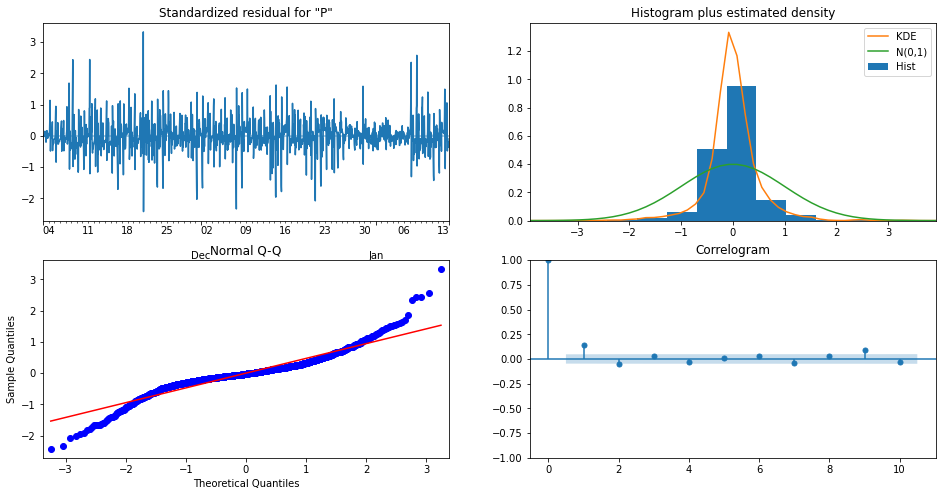

In [58]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()


In [177]:
pred = results.predict(start=pd.to_datetime('2020-01-14'), end=pd.to_datetime('2020-02-01'))

In [179]:
pred = results.predict(start=pd.to_datetime('2019-11-02'), end=pd.to_datetime('2020-01-13'))

In [180]:
# pred.tail(30)
len(pred)

1729

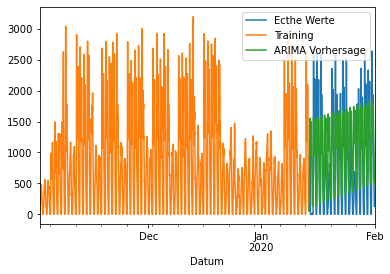

In [63]:
test.plot(label="Ecthe Werte")
# %matplotlib qt
training.plot(label="Training")
pred.plot(label = "ARIMA Vorhersage")
# plt.title("ARIMA-Vorhersage",fontsize=45)
# plt.xlabel("Datum",fontsize=35)
# plt.ylabel("Eingänge der Passagiere",fontsize=35)

plt.legend()
plt.show()

<h2> Beste Ergebnisse BISHER!

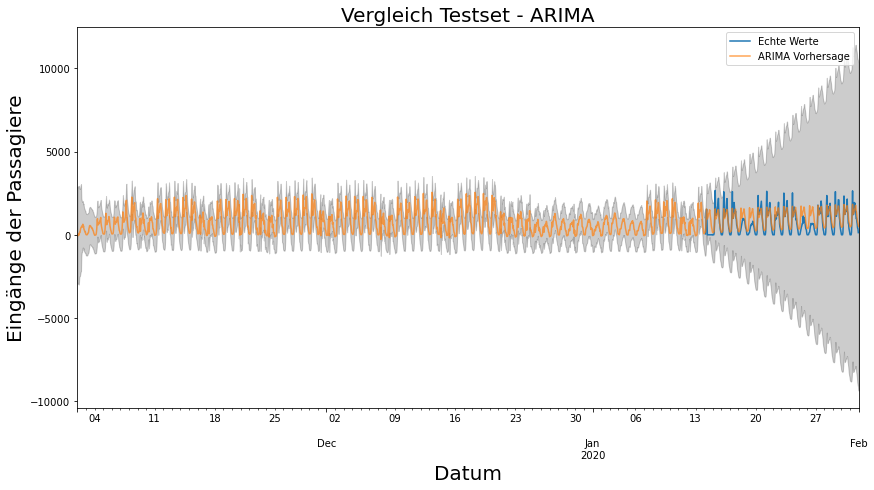

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2019-11-02'),end=pd.to_datetime('2020-02-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = test.loc["2020-01-14":].plot(label='Echte Werte')
pred.predicted_mean.plot(ax=ax, label='ARIMA Vorhersage', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Vergleich Testset - ARIMA', fontsize = 20)

ax.set_xlabel('Datum', fontsize = 20)
ax.set_ylabel('Eingänge der Passagiere', fontsize=20)
plt.legend()
plt.show()

SARIMA

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(training,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [92]:
mod = sm.tsa.statespace.SARIMAX(training,
                                order=(1, 1, 6),
                                seasonal_order=(1, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\ramav\anaconda3\envs\Modell_Prophet\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.206      4.554      0.000       0.534       1.340
ma.L1         -1.1944      0.221     -5.411      0.000      -1.627      -0.762
ma.L2          0.1309      0.169      0.775      0.438      -0.200       0.462
ma.L3         -0.2035      0.204     -1.000      0.318      -0.603       0.196
ma.L4          0.2659      0.262      1.016      0.309      -0.247       0.779
ma.L5         -0.0214      0.262     -0.082      0.935      -0.536       0.493
ma.L6          0.0304      0.165      0.184      0.854      -0.294       0.354
ar.S.L12      -0.9974      0.008   -122.107      0.000      -1.013      -0.981
ma.S.L12       0.0414      0.078      0.533      0.594      -0.111       0.193
ma.S.L24      -0.7873      0.053    -14.883      0.000      -0.891      -0.684
sigma2      2.536e+05   1.34e+04     18.956      0.0

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

<h2> Trainingsdaten wurden gut gelernt?

In [31]:
pred = results.predict(start=pd.to_datetime('2019-11-01 04:00:00'), end=pd.to_datetime('2020-01-31 23:00:00'),dynamic=False) #,dynamic=False
print(pred)
#pred = results.predict(start=pd.to_datetime('2020-01-14'), end=pd.to_datetime('2020-01-31'), typ = "levels" ) #,dynamic=False


2019-11-01 04:00:00       0.000000
2019-11-01 05:00:00      39.369882
2019-11-01 06:00:00     119.730437
2019-11-01 07:00:00     114.077276
2019-11-01 08:00:00     104.851300
                          ...     
2020-01-31 19:00:00    1188.331630
2020-01-31 20:00:00     917.771913
2020-01-31 21:00:00     780.238633
2020-01-31 22:00:00     695.552654
2020-01-31 23:00:00     550.283590
Freq: H, Name: predicted_mean, Length: 2204, dtype: float64


<AxesSubplot:>

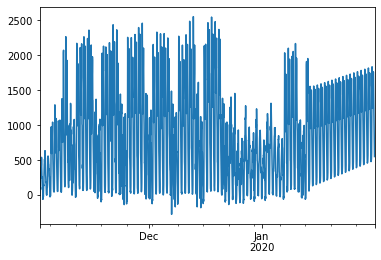

In [32]:
training.plot()
test.plot()
%matplotlib inline
pred.plot()

In [36]:
%matplotlib qt

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2019-11-02'),end=pd.to_datetime('2020-02-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = test.loc["2020-01-14":].plot(label='Echte Werte')
# training.plot()
pred.predicted_mean.plot(ax=ax, label='ARIMA Vorhersage')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Vorhersagemodell - ARIMA', fontsize = 45)
ax.set_xlabel('Datum', fontsize = 25)
ax.set_ylabel('Eingänge der Passagiere', fontsize = 25)
plt.grid(color='grey', linewidth=0.5)
plt.legend()
plt.show()

In [14]:
plt.close("all")

In [ ]:
# pred_uc = results.get_forecast(steps=250)
# pred_uc.predicted_mean.plot( label='Forecast')
# test.plot()
# plt.show()

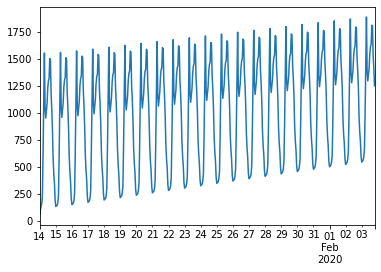

In [34]:
pred_uc = results.get_forecast(steps=500)
pred_uc.predicted_mean.plot( label='Forecast')
plt.show()

In [ ]:

# pred_ci = pred_uc.conf_int()

# ax = test.loc["2020-01-14":].plot(label='observed')

# pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('Furniture Sales')

# plt.legend()
# plt.show()

In [70]:
%matplotlib qt

<h1> Vergleich der modelle

In [104]:
test

,P hochgerechnet
Datum,
2020-01-14 04:00:00,54.000000
2020-01-14 05:00:00,737.500000
2020-01-14 06:00:00,1354.989800
2020-01-14 07:00:00,1530.000000
2020-01-14 08:00:00,880.543100
...,...
2020-01-31 20:00:00,663.568328
2020-01-31 21:00:00,406.522410
2020-01-31 22:00:00,356.000000


In [105]:
test = test.set_index('Datum')
test.index

KeyError: "None of ['Datum'] are in the columns"

<h2>ARIMA

In [106]:
training_forecast_aufTest = training_forecast_aufTest.set_index('ds')

# tag = pred['2020-01-21':'2020-01-21']
# tag2 = test['2020-01-21':'2020-01-21']

102.17859327272792

In [166]:
plt.plot(tag, color= "darkgreen", label ="ARIMA")
plt.plot(tag2.index, tag2["P hochgerechnet"],color = "blue", label="Echte Werte")
plt.title('Wochentag Testset - ARIMA', fontsize = 45)
# plt.xlabel('Datum', fontsize = 25)
plt.ylabel('Eingänge der Passagiere', fontsize = 50)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)
plt.grid(color='grey', linewidth=0.5)
plt.legend(fontsize=50) 
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.show()

<h2>LSTM

In [161]:
# by_hour_df = by_hour_df.set_index('Datum')

# tag = by_hour_df['2020-01-19':'2020-01-21']
tag2 = test['2020-01-19':'2020-01-19']

In [150]:
predicted_stock_price[1]

array([635.3088], dtype=float32)

In [164]:
plt.plot(by_hour_df.loc[1554:,"Datum"],predicted_stock_price,color="red" ,label = "LSTM")
plt.plot(tag2.index, tag2["P hochgerechnet"],color = "blue", label="Echte Werte")
plt.title('Wochenende Testset - LSTM', fontsize = 45)
# plt.xlabel('Datum', fontsize = 25)
plt.ylabel('Eingänge der Passagiere', fontsize = 50)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)
plt.grid(color='grey', linewidth=0.5)
plt.legend(fontsize=50) 
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.show()


<h2>Prophet

In [14]:
training_forecast_aufTest = training_forecast_aufTest.set_index('ds')

tag = training_forecast_aufTest['2020-01-19':'2020-01-19']
tag2 = test['2020-01-19':'2020-01-19']

TypeError: cannot do slice indexing on RangeIndex with these indexers [2020-01-19] of type str

In [12]:
plt.plot(tag.index,tag["yhat"], color = "orange", label ="Prophet")
plt.plot(tag2.index, tag2["P hochgerechnet"],color = "blue", label="Echte Werte")
plt.title('Wochenende Testset - Prophet', fontsize = 50)
# plt.xlabel('Datum', fontsize = 25)
plt.ylabel('Eingänge der Passagiere', fontsize = 50)
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)
plt.grid(color='grey', linewidth=0.5)
plt.legend(fontsize=50) 
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.show()



NameError: name 'tag' is not defined

Alle Drei übereinander gelagert

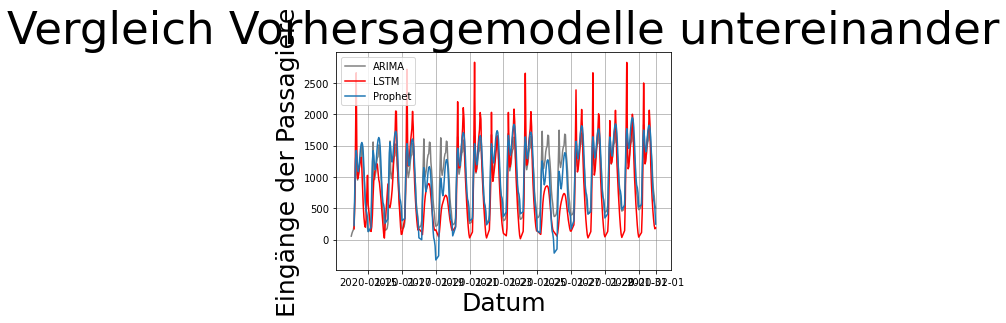

In [51]:
plt.plot(pred, color= "grey", label ="ARIMA")
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price,color="red" ,label = "LSTM")
plt.plot(training_forecast_aufTest["ds"],training_forecast_aufTest["yhat"], label ="Prophet")
plt.title('Vergleich Vorhersagemodelle untereinander', fontsize = 45)
plt.xlabel('Datum', fontsize = 25)
plt.ylabel('Eingänge der Passagiere', fontsize = 25)
plt.grid(color='grey', linewidth=0.5)
plt.legend()
plt.show()

Kapazität und LSTM

In [115]:
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price,color="darkgreen" ,label = "LSTM", linewidth=5, marker="D", markersize=15)
plt.plot(by_hour_df.loc[1554:, "Datum"],by_hour_df.loc[1554:, "min_kapaz"],color = "blue", label="Kapazität", linewidth=5, marker="D", markersize=15)
plt.title('Kapazität - LSTM: Wochentag', fontsize = 50)
plt.xlabel('Formatierung X-Achse: Monat-Tag Stunde', fontsize = 50)
plt.ylabel('Eingänge der Passagiere', fontsize = 50)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.grid(color='grey', linewidth=2)
plt.legend(fontsize=40)  

plt.show()




<h1> MEGAPLOT alle drei mit echten daten übergelagert

In [107]:
test

,P hochgerechnet
Datum,
2020-01-14 04:00:00,54.000000
2020-01-14 05:00:00,737.500000
2020-01-14 06:00:00,1354.989800
2020-01-14 07:00:00,1530.000000
2020-01-14 08:00:00,880.543100
...,...
2020-01-31 20:00:00,663.568328
2020-01-31 21:00:00,406.522410
2020-01-31 22:00:00,356.000000


In [120]:
plt.plot(pred, color= "red", label ="ARIMA", linewidth=4, marker="D", markersize=15)
plt.plot(by_hour_df.loc[1554:, "Datum"],predicted_stock_price, color="green" ,label = "LSTM", linewidth=4, marker="D", markersize=15)
plt.plot(training_forecast_aufTest.index,training_forecast_aufTest["yhat"] ,color= "orange", label ="Prophet", linewidth=4, marker="D", markersize=15)
plt.plot(test.index, test["P hochgerechnet"],color = "blue", label="Echte Werte", linewidth=5, marker="D", markersize=15)
plt.title('Vergleich Wochentag', fontsize = 50)
plt.xlabel('Formatierung X-Achse: Monat-Tag Stunde', fontsize = 50)
plt.ylabel('Eingänge der Passagiere', fontsize = 50)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.grid(color='grey', linewidth=2)
plt.legend(fontsize=30) 
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.show()

In [88]:
test.index

DatetimeIndex(['2020-01-14 04:00:00', '2020-01-14 05:00:00',
               '2020-01-14 06:00:00', '2020-01-14 07:00:00',
               '2020-01-14 08:00:00', '2020-01-14 09:00:00',
               '2020-01-14 10:00:00', '2020-01-14 11:00:00',
               '2020-01-14 12:00:00', '2020-01-14 13:00:00',
               ...
               '2020-01-31 15:00:00', '2020-01-31 16:00:00',
               '2020-01-31 17:00:00', '2020-01-31 18:00:00',
               '2020-01-31 19:00:00', '2020-01-31 20:00:00',
               '2020-01-31 21:00:00', '2020-01-31 22:00:00',
               '2020-01-31 23:00:00', '2020-01-31 23:59:59'],
              dtype='datetime64[ns]', name='Datum', length=378, freq=None)

<h2> Welches Modell hat die niedrigste Differenz zu den echten Werten?

In [37]:
# len(pred)
# pred.index[21]
# pred.drop(pred.index[22])

# if pred.index != test.index:
#     print("yes")
# pred.tail(40)
# type(pred)
# pred[pred.index != 'Tina']
# # print(len(arima_df),len(test),len(predicted_stock_price),len(training_forecast_aufTest))
# # training_forecast_aufTest.tail()
# for i, wert in enumerate(test):
#     print(wert)
#     print(type(wert))
# arima_df["predicted_mean"][0]

for i in range(0,428):
    
    if  pred.index[i] not in test.index:
        print(pred.index[i])
        pred = pred.drop(pred.index[i])
        
        
pred.to_csv("pred.csv")

In [54]:
test.head(30)

,P hochgerechnet
Datum,
2020-01-14 04:00:00,54.000000
2020-01-14 05:00:00,737.500000
2020-01-14 06:00:00,1354.989800
2020-01-14 07:00:00,1530.000000
2020-01-14 08:00:00,880.543100
2020-01-14 09:00:00,0.000000
2020-01-14 10:00:00,0.000000
2020-01-14 11:00:00,0.000000
2020-01-14 12:00:00,0.000000


<h2> CSV DATEI BEARBEITEN UND DANN WEITER MIT DER NÄCHSTEN ZELLE

In [39]:
#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

arima_df= pd.read_csv('pred.csv', index_col=None, header= 0,decimal = ".", delimiter=",")

arima_df

,Unnamed: 0,predicted_mean
0,2020-01-14 04:00:00,232.004992
1,2020-01-14 05:00:00,610.346842
2,2020-01-14 06:00:00,1069.195109
3,2020-01-14 07:00:00,1553.696137
4,2020-01-14 08:00:00,1040.129788
...,...,...
373,2020-01-31 20:00:00,917.771913
374,2020-01-31 21:00:00,780.238633
375,2020-01-31 22:00:00,695.552654
376,2020-01-31 23:00:00,550.283590


In [133]:
# len(arima_df,test)

# for i in range(0,379):
# #     print(test["P hochgerechnet"][i])
#     print(np.diff( [test["P hochgerechnet"][i] ,training_forecast_aufTest["yhat"][i]]))


# np.diff( [test["P hochgerechnet"][1] ,training_forecast_aufTest["yhat"][1]])[0]

# print(training_forecast_aufTest["yhat"][1],test["P hochgerechnet"][1])
(abs(np.diff( [test["P hochgerechnet"][1], predicted_stock_price[1][0]])[0]))

-52.5653076171875

In [55]:
print(len(predicted_stock_price))
print(len(test))
print(len(training_forecast_aufTest))
print(len(arima_df))

378
378
378
378


In [70]:
predicted_stock_price[150][0]

2438.895

ERGEBNIS DER DIFFERENZ

In [165]:
vergleich_df = pd.DataFrame()


for i in range(0,378):
    
    row_vergleich = {'Testset': test["P hochgerechnet"][i], 
                     'Prophet': (abs(np.diff( [test["P hochgerechnet"][i], training_forecast_aufTest["yhat"][i]])[0])),
                     'LSTM': (abs(np.diff( [test["P hochgerechnet"][i], predicted_stock_price[i][0]])[0])), 
                     'ARIMA': (abs(np.diff( [test["P hochgerechnet"][i], arima_df["predicted_mean"][i]])[0])) }
    
    print("Erwartet: ", test["P hochgerechnet"][i])
    print("Differenz dazu:", 
          (abs(np.diff( [test["P hochgerechnet"][i], training_forecast_aufTest["yhat"][i]])[0])),
          (abs(np.diff( [test["P hochgerechnet"][i], predicted_stock_price[i][0]])[0])), 
          (abs(np.diff( [test["P hochgerechnet"][i], arima_df["predicted_mean"][i]])[0])))
    
    vergleich_df = vergleich_df.append(row_vergleich , ignore_index = True)

Erwartet:  54.0
Differenz dazu: 172.62583640998287 119.83515930175781 178.00499153139896
Erwartet:  737.5
Differenz dazu: 69.06502843689918 52.5653076171875 127.15315824329127
Erwartet:  1354.9898
Differenz dazu: 94.12488542434266 180.26862285156244 285.79469067771356
Erwartet:  1530.0
Differenz dazu: 107.52871487499465 852.127197265625 23.696136521042718
Erwartet:  880.5431
Differenz dazu: 447.70155629264207 518.2048248046875 159.58668829183478
Erwartet:  0.0
Differenz dazu: 1158.9743207963038 1123.6004638671875 951.0835776148192
Erwartet:  0.0
Differenz dazu: 1085.3391392642238 1098.5784912109375 1019.1021538203764
Erwartet:  0.0
Differenz dazu: 1155.4449660972173 1115.9586181640625 1088.2035276523616
Erwartet:  0.0
Differenz dazu: 1303.1590671758104 1153.4068603515625 1230.3878481299107
Erwartet:  0.0
Differenz dazu: 1438.903778005823 1182.9639892578125 1297.0508965584563
Erwartet:  0.0
Differenz dazu: 1521.1080765408296 1160.521728515625 1316.840195904039
Erwartet:  0.0
Differenz d

In [286]:
print("Summe der Differenzen zum Test-Set")
print("LSTM: \t", vergleich_df["LSTM"].sum())
print("Prophet: ", vergleich_df["Prophet"].sum())
print("ARIMA: \t", vergleich_df["ARIMA"].sum())

Summe der Differenzen zum Test-Set
LSTM: 	 68051.47362212754
Prophet:  119227.57856466262
ARIMA: 	 132266.3478219547


<h2>RMSE

In [179]:
from sklearn.metrics import mean_squared_error

In [213]:
prophet_error = mean_squared_error(test["P hochgerechnet"],training_forecast_aufTest["yhat"], squared = False)
print("Prophet RMSE ERROR: ", prophet_error )

Prophet RMSE ERROR:  414.7687854288369


In [285]:
print("Prophet MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,training_forecast_aufTest["yhat"].values)).mean()

Prophet MSE:


172033.14536611256

In [269]:
lstm_error = mean_squared_error(test["P hochgerechnet"],predicted_stock_price, squared = False)
print("LSTM RMSE ERROR: ", lstm_error )

LSTM RMSE ERROR:  340.1841462147975


In [275]:
print("LSTM MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,predicted_stock_price[0][0])).mean()

LSTM MSE:


790437.1420288807

In [228]:
arima_error = mean_squared_error(test["P hochgerechnet"],arima_df["predicted_mean"], squared = False)
print("ARIMA RMSE ERROR: ", arima_error )

ARIMA RMSE ERROR:  460.3343319325193


In [232]:
print("ARIMA MSE:")
np.square(np.subtract(test["P hochgerechnet"].values,arima_df["predicted_mean"].values)).mean()

ARIMA MSE:


211907.69715575885

In [188]:
len(vergleich_df)

378

In [189]:
vergleich_df.tail()
vergleich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ARIMA    378 non-null    float64
 1   LSTM     378 non-null    float64
 2   Prophet  378 non-null    float64
 3   Testset  378 non-null    float64
dtypes: float64(4)
memory usage: 11.9 KB


In [190]:
vergleich_df.plot()

<AxesSubplot:>